
# Project 2 – Section 2.1
## Importance Sampling for European Call Options
This notebook implements the numerical tasks of Section 2.1:
1. Crude Monte Carlo estimator using Euler–Maruyama (EM).
2. Importance Sampling (IS) by modifying the drift (interest rate).
3. Adaptive IS strategy based on variance minimization (Algorithm 6.4 in the notes).
4. PDE-based optimal control importance sampling, using the Kolmogorov backward equation.

The parameters and guidelines follow the project specification
"Importance Sampling by Optimal Control in Option Pricing" and
the lecture notes chapter "6.2 Importance Sampling" (Algorithms 6.2, 6.3, 6.4 and Example 6.4).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from math import log, sqrt, exp
from scipy.stats import norm 
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import RegularGridInterpolator

import plotly.graph_objects as go
from tqdm import tqdm
import time

## Global parameters and reference Black–Scholes price
We use the parameters specified in Section 2.1 of the project:

- Interest rate: r = 5%
- Volatility: sigma = 0.51
- Maturity: T = 0.2
- Initial price: S0 = 100
- Strike: K = 120

For the EM scheme:
- Number of subintervals: M = 100
- Time step: dt = T / M

In [ ]:
np.random.seed(42)  # for reproducibility

# Parameters from the project specification
r = 0.05
sigma = 0.51
T = 0.2
S0 = 100.0
K = 120.0

M_em = 100  # number of EM steps
dt_em = T / M_em

# Payoff function for a discounted European Call
def payoff_call_discounted(S_T):
    return np.exp(-r * T) * np.maximum(S_T - K, 0.0)

# Black–Scholes closed form for reference
def bs_call_price(S0, K, r, sigma, T):
    if T <= 0:
        return max(S0 - K, 0.0)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

# Reference Black–Scholes price
bs_price = bs_call_price(S0, K, r, sigma, T)
print(f"Black–Scholes price: {bs_price}")

## Euler–Maruyama simulation of the underlying SDE
We consider the Black–Scholes model:

$
dS(t) = r S(t)\,dt + \sigma S(t)\,dW(t),
$

and approximate it by Euler–Maruyama on an equispaced grid:

$
S_{m+1} = S_m + r S_m \Delta t + \sigma S_m \Delta W_m,
\quad \Delta W_m \sim \mathcal{N}(0, \Delta t).
$

In [ ]:
def simulate_gbm_em_paths(N, S0, r, sigma, T, M):
    """
    Simulate N paths of GBM using Euler-Maruyama.
    
    Returns:
        S_paths: array of shape (N, M+1) with full paths
    """
    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    S_paths = np.empty((N, M + 1))
    S_paths[:, 0] = S0
    
    for m in range(M):
        Z = np.random.randn(N)
        dW = sqrt_dt * Z
        S = S_paths[:, m]
        S_paths[:, m + 1] = S + r * S * dt + sigma * S * dW
    return S_paths

## 2.1.1 Crude Monte Carlo estimator
- Simulate trajectories of the SDE using EM with M = 100.
- Compute the estimator
   $
   \hat{Z}_{\Delta t} = \frac{1}{N} \sum_{i=1}^N \psi(S_T^{(i)}),
   $
   where $\psi(S_T) = e^{-rT}(S_T - K)^+$.
 - Compare $\hat{Z}_{\Delta t}$ to the exact Black–Scholes price.
 - Try various sample sizes `N_list`.

In [4]:
def mc_european_call_em(N, S0, r, sigma, T, M):
    """
    Crude MC estimator using Euler-Maruyama.
    
    Returns:
        estimate, std_estimator
    """
    S_paths = simulate_gbm_em_paths(N, S0, r, sigma, T, M)
    S_T = S_paths[:, -1]
    payoffs = payoff_call_discounted(S_T)
    est = np.mean(payoffs)
    std = np.std(payoffs, ddof=1)
    return est, std

# Example: run for a range of N
N_list = [10, 100, 1000, 10_000, 100_000, 1_000_000]

cmc_results = []
for N in N_list:
    est, std = mc_european_call_em(N, S0, r, sigma, T, M_em)
    cmc_results.append((N, est, std))

cmc_results

var_crude_ref = cmc_results[-1][2] ** 2
print(f"Variance of crude MC estimator with N={N_list[-1]}: {var_crude_ref}")

Variance of crude MC estimator with N=1000000: 87.97112076331672


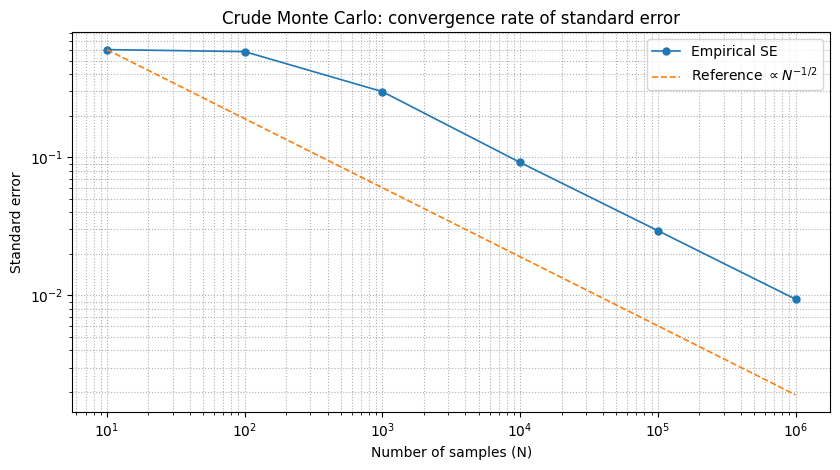

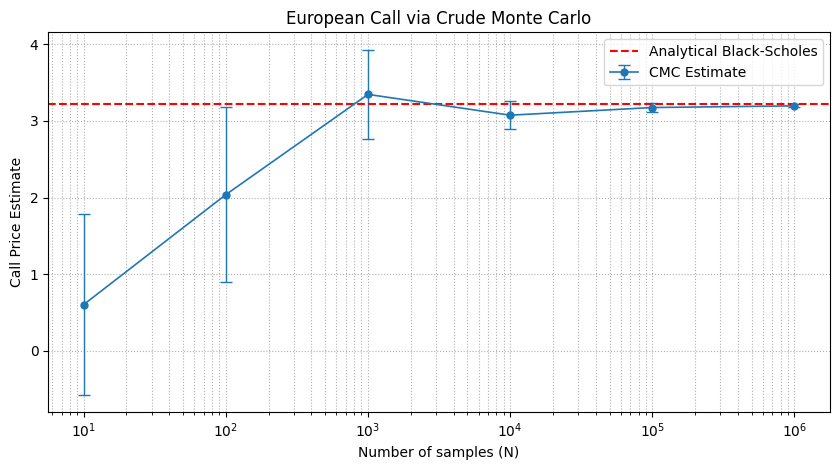


95% Confidence Intervals for Crude Monte Carlo estimates:

N =      10 | Estimate = 0.60167107 | 95% CI = [-0.57758255, 1.78092469] | CI length = 2.35850724e+00 | Std dev = 1.90265097
N =     100 | Estimate = 2.03745200 | 95% CI = [0.89701657, 3.17788742] | CI length = 2.28087084e+00 | Std dev = 5.81865498
N =    1000 | Estimate = 3.34665411 | 95% CI = [2.76149578, 3.93181244] | CI length = 1.17031666e+00 | Std dev = 9.44115876
N =   10000 | Estimate = 3.07502644 | 95% CI = [2.89534484, 3.25470805] | CI length = 3.59363208e-01 | Std dev = 9.16759724
N =  100000 | Estimate = 3.17518520 | 95% CI = [3.11757527, 3.23279513] | CI length = 1.15219862e-01 | Std dev = 9.29499723
N = 1000000 | Estimate = 3.19680400 | 95% CI = [3.17842092, 3.21518707] | CI length = 3.67661495e-02 | Std dev = 9.37929212


In [5]:
# ============================================================
# Prepare data for plots
# ============================================================

# Extract arrays from cmc_results = [(N, est, std_payoff), ...]
N_arr = np.array([res[0] for res in cmc_results], dtype=float)
est_arr = np.array([res[1] for res in cmc_results], dtype=float)
std_payoff_arr = np.array([res[2] for res in cmc_results], dtype=float)

# Standard error of the Monte Carlo estimator
se_arr = std_payoff_arr / np.sqrt(N_arr)

# Quantile for asymptotic 95% confidence intervals
z975 = norm.ppf(0.975)

# ============================================================
# Plot 1: Convergence rate of the standard error (log-log)
# ============================================================

plt.figure(figsize=(8.5, 4.8))

# Empirical standard error
plt.loglog(
    N_arr, se_arr,
    'o-',
    linewidth=1.2,
    markersize=5,
    label="Empirical SE"
)

# Reference slope ~ 1/sqrt(N)
ref_se = se_arr[0] * np.sqrt(N_arr[0]) / np.sqrt(N_arr)
plt.loglog(
    N_arr, ref_se,
    '--',
    linewidth=1.2,
    label=r"Reference $\propto N^{-1/2}$"
)

plt.xlabel("Number of samples (N)")
plt.ylabel("Standard error")
plt.title("Crude Monte Carlo: convergence rate of standard error")

plt.grid(True, which='both', linestyle=':', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: MC price estimates with 95% CI and analytical reference

plt.figure(figsize=(8.5, 4.8))

# 95% CI half-widths
yerr = z975 * se_arr

# Crude Monte Carlo estimates with confidence intervals
plt.errorbar(
    N_arr,
    est_arr,
    yerr=yerr,
    fmt='o-',
    markersize=5,
    linewidth=1.2,
    capsize=4,
    capthick=1.0,
    elinewidth=1.0,
    label="CMC Estimate"
)

# Analytical Black–Scholes reference
plt.axhline(
    bs_price,
    color='red',
    linestyle='--',
    linewidth=1.5,
    label="Analytical Black-Scholes"
)

plt.xscale('log')
plt.xlabel("Number of samples (N)")
plt.ylabel("Call Price Estimate")
plt.title("European Call via Crude Monte Carlo")

plt.grid(True, which='both', linestyle=':', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()

# Print numerical 95% confidence intervals for IS estimates
print("\n95% Confidence Intervals for Crude Monte Carlo estimates:\n")

for N, est, std in cmc_results:
    se = std / np.sqrt(N)
    ci_low = est - z975 * se
    ci_high = est + z975 * se
    ci_length = ci_high - ci_low

    print(
        f"N = {N:>7d} | "
        f"Estimate = {est:.8f} | "
        f"95% CI = [{ci_low:.8f}, {ci_high:.8f}] | "
        f"CI length = {ci_length:.8e} | "
        f"Std dev = {std:.8f}"
    )

## 2.1.2 Importance Sampling with modified drift

We implement the IS estimator as in Algorithm 6.2 and Example 6.4 in the notes:

- Work on the log-price: $ X_T = \log(S_T / S_0) $.
- Under the original model: $ X_T \sim \mathcal{N}(\mu_r, \sigma_X^2) $.
- Under the IS model: $ \tilde X_T \sim \mathcal{N}(\mu_{\tilde r}, \sigma_X^2) $.
- Likelihood ratio: $ w(x) = f_r(x) / f_{\tilde r}(x) $.
- Estimator:
   $
   \hat{Z}_{\text{IS}} =
   \frac{1}{N}\sum_{i=1}^N \psi(S_0 e^{\tilde X_T^{(i)}}) w(\tilde X_T^{(i)}).
   $

In [6]:
def log_price_params(r_param, sigma, T):
    """
    Mean and variance of log(S_T / S0) under Black-Scholes with rate r_param.
    """
    mu = (r_param - 0.5 * sigma ** 2) * T
    var = sigma ** 2 * T
    return mu, var

def normal_pdf(x, mu, var):
    """
    Normal pdf with mean mu and variance var at x.
    """
    return (1.0 / np.sqrt(2.0 * np.pi * var)) * np.exp(-0.5 * (x - mu) ** 2 / var)

def is_fixed_rtilde(N, S0, K, r, r_tilde, sigma, T):
    """
    Importance sampling estimator for the European call by changing the drift
    from r to r_tilde, following Example 6.4.
    
    Returns:
        estimate, std_estimator
    """
    mu_r, var = log_price_params(r, sigma, T)
    mu_rt, _ = log_price_params(r_tilde, sigma, T)
    
    # Sample under the IS distribution: N(mu_rt, var)
    X_tilde = np.random.randn(N) * np.sqrt(var) + mu_rt
    S_T_tilde = S0 * np.exp(X_tilde)

    # Payoffs under original payoff function              
    payoffs = payoff_call_discounted(S_T_tilde)          
    
    # Likelihood ratio w(x) = f_r(x) / f_rtilde(x)     
    f_r_vals = normal_pdf(X_tilde, mu_r, var)          
    f_rt_vals = normal_pdf(X_tilde, mu_rt, var)        
    w = f_r_vals / f_rt_vals                           
    
    weighted_payoffs = payoffs * w                   
    est = np.mean(weighted_payoffs)
    std = np.std(weighted_payoffs, ddof=1)
    return est, std

# We choose the IS drift that centers log-price at log(K)
r_tilde = np.log( K / S0 ) / T + 0.5 * sigma**2  
print(f"Using r_tilde = {r_tilde:.4f} for importance sampling. \n")

is_results_fixed = []
for N in N_list:
    est, std = is_fixed_rtilde(N, S0, K, r, r_tilde, sigma, T)
    is_results_fixed.append((N, est, std))

print("\n95% Confidence Intervals for Crude Monte Carlo estimates:\n")

for N, est, std in is_results_fixed:
    se = std / np.sqrt(N)
    ci_low = est - z975 * se
    ci_high = est + z975 * se
    ci_length = ci_high - ci_low

    print(
        f"N = {N:>7d} | "
        f"Estimate = {est:.8f} | "
        f"95% CI = [{ci_low:.8f}, {ci_high:.8f}] | "
        f"CI length = {ci_length:.8e} | "
        f"Std dev = {std:.8f}"
    )


print("\nAbsolute errors from Black-Scholes price:")
for res in is_results_fixed:
    print("\t For N =  " + str(res[0]) + ": " + str(abs(res[1] - bs_price)))

Using r_tilde = 1.0417 for importance sampling. 


95% Confidence Intervals for Crude Monte Carlo estimates:

N =      10 | Estimate = 0.38565910 | 95% CI = [-0.16994320, 0.94126141] | CI length = 1.11120461e+00 | Std dev = 0.89642910
N =     100 | Estimate = 2.97973695 | 95% CI = [2.27875037, 3.68072354] | CI length = 1.40197318e+00 | Std dev = 3.57652790
N =    1000 | Estimate = 3.13396323 | 95% CI = [2.90574671, 3.36217975] | CI length = 4.56433031e-01 | Std dev = 3.68212882
N =   10000 | Estimate = 3.17783771 | 95% CI = [3.10546230, 3.25021313] | CI length = 1.44750833e-01 | Std dev = 3.69269113
N =  100000 | Estimate = 3.22670553 | 95% CI = [3.20372276, 3.24968831] | CI length = 4.59655464e-02 | Std dev = 3.70812478
N = 1000000 | Estimate = 3.21698063 | 95% CI = [3.20971107, 3.22425019] | CI length = 1.45391134e-02 | Std dev = 3.70902566

Absolute errors from Black-Scholes price:
	 For N =  10: 2.831970256064484
	 For N =  100: 0.23789240375061382
	 For N =  1000: 0.08366612840841

## Quantification of Variance Reduction - Crude Monte Carlo vs Importance Sampling

In [7]:
VR_cmc_vs_is_fixed = []
for (N_cmc, _, std_cmc), (N_is, _, std_is) in zip(cmc_results, is_results_fixed):
    print(std_cmc, std_is)
    vr = (std_cmc ** 2) / (std_is ** 2)
    VR_cmc_vs_is_fixed.append((N_cmc, vr))

VR_cmc_vs_is_fixed

1.9026509711725623 0.8964291025331691
5.818654983230304 3.576527902332347
9.441158761672357 3.6821288240824783
9.167597243983503 3.6926911330033714
9.294997225897374 3.708124781979618
9.379292124852318 3.7090256637309618


[(10, np.float64(4.504912493424515)),
 (100, np.float64(2.6468051920141193)),
 (1000, np.float64(6.574347319541867)),
 (10000, np.float64(6.163467121468904)),
 (100000, np.float64(6.283329699982968)),
 (1000000, np.float64(6.394704026106168))]

## Confidence Interval plots

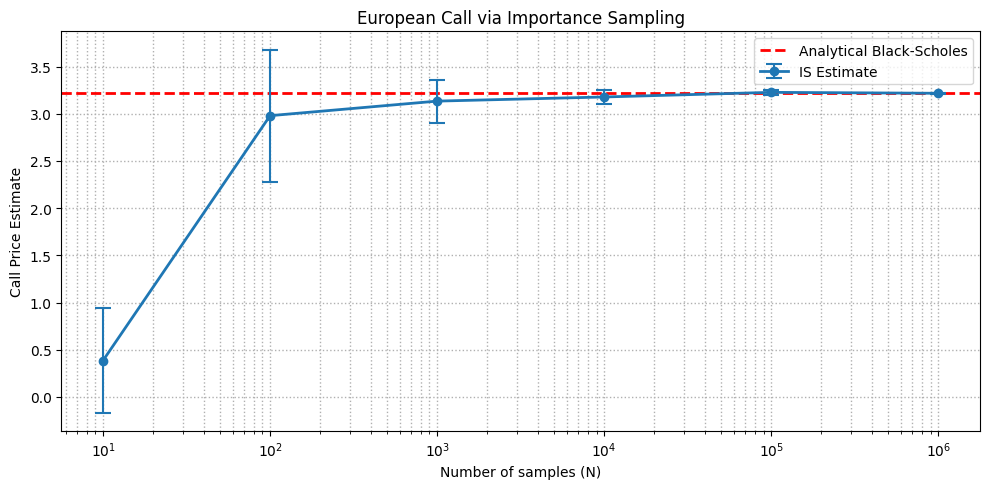


95% Confidence Intervals for Importance Sampling estimates:

N =      10 | Estimate = 0.38565910 | 95% CI = [-0.16994320, 0.94126141] | CI length = 1.11120461e+00 | Std Dev = 0.89642910 | Variance = 0.80358514
N =     100 | Estimate = 2.97973695 | 95% CI = [2.27875037, 3.68072354] | CI length = 1.40197318e+00 | Std Dev = 3.57652790 | Variance = 12.79155184
N =    1000 | Estimate = 3.13396323 | 95% CI = [2.90574671, 3.36217975] | CI length = 4.56433031e-01 | Std Dev = 3.68212882 | Variance = 13.55807268
N =   10000 | Estimate = 3.17783771 | 95% CI = [3.10546230, 3.25021313] | CI length = 1.44750833e-01 | Std Dev = 3.69269113 | Variance = 13.63596780
N =  100000 | Estimate = 3.22670553 | 95% CI = [3.20372276, 3.24968831] | CI length = 4.59655464e-02 | Std Dev = 3.70812478 | Variance = 13.75018940
N = 1000000 | Estimate = 3.21698063 | 95% CI = [3.20971107, 3.22425019] | CI length = 1.45391134e-02 | Std Dev = 3.70902566 | Variance = 13.75687137


In [8]:
# Plot: IS estimates with 95% CI + Analytical Black–Scholes line

# Extract arrays from is_results_fixed = [(N, est, std_weighted_payoff), ...]
N_is = np.array([res[0] for res in is_results_fixed], dtype=float)
est_is = np.array([res[1] for res in is_results_fixed], dtype=float)
std_is_payoff = np.array([res[2] for res in is_results_fixed], dtype=float)

# Standard error of the IS estimator
se_is = std_is_payoff / np.sqrt(N_is)

# 95% asymptotic CI half-width
z975 = norm.ppf(0.975)
yerr_is = z975 * se_is

plt.figure(figsize=(10, 5))

# Analytical BS reference
plt.axhline(bs_price, color='red', linestyle='--', linewidth=2, label='Analytical Black-Scholes')

# IS estimate with CI error bars
plt.errorbar(
    N_is, est_is,
    yerr=yerr_is,
    fmt='o-',
    markersize=6,
    linewidth=2,
    capsize=6,
    capthick=1.5,
    elinewidth=1.5,
    label='IS Estimate'
)

plt.xscale('log')
plt.xlabel('Number of samples (N)')
plt.ylabel('Call Price Estimate')
plt.title('European Call via Importance Sampling')

plt.grid(True, which='both', linestyle=':', linewidth=1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Print numerical 95% confidence intervals for IS estimates
print("\n95% Confidence Intervals for Importance Sampling estimates:\n")

for N, est, std in is_results_fixed:
    se = std / np.sqrt(N)
    ci_low = est - z975 * se
    ci_high = est + z975 * se
    ci_length = ci_high - ci_low

    print(
        f"N = {N:>7d} | "
        f"Estimate = {est:.8f} | "
        f"95% CI = [{ci_low:.8f}, {ci_high:.8f}] | "
        f"CI length = {ci_length:.8e} | "
        f"Std Dev = {std:.8f} | "
        f"Variance = {std**2:.8f}"
    )

## 2.1.3 Adaptive Importance Sampling with variance minimization

We implement the adaptive IS estimator as in Algorithm 6.4 in the lecture notes. We treat the parameter as $\theta = \tilde{r}$ and:

- Use samples from $f(\cdot, \hat{\theta})$ (current $\tilde{r}$).
- Update $\theta$ by approximately minimizing the empirical counterpart of

   $
   J(\theta) =
   \mathbb{E}_{\theta_0}\bigg[ \phi^2(X) \frac{f(X ; \theta_0)}{f(X ; \theta)} \bigg] 
   = \mathbb{E}_{\hat{\theta}}\Bigg[ \phi^2(X) \frac{f^2(X;\theta_0)}{f(X;\theta_0)f(X;\hat{\theta})} \Bigg]
   $,

   where $\theta_0$ is the original parameter $r$ (the risk-free rate). We implement the minimization over a grid of candidate values $\tilde{r}$.

In [9]:
def adaptive_is_rtilde(
    S0, K, r, sigma, T,
    tol=1e-3, alpha=0.05,
    N_bar=1000, gamma=2.0,
    r_min=0.05, r_max=20.0,
    n_grid=100,                 # coarse grid size
    n_refine=501,               # refined grid size around coarse minimizer
    refine_half_width=0.25,     # refine interval: [best-hw, best+hw]
    max_iter=20,
    random_seed=123,
    eps_denom=1e-300
):
    """
    Adaptive IS for European call with variance-minimization objective J(theta),
    following Algorithm 6.3/6.4.

    The minimization is performed via a two-stage grid search, 
    first minimizing the empirical J(theta) over a course grid, then refining around the best candidate.  
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    c = norm.ppf(1 - alpha / 2.0)

    # Precompute variance of X = log(S_T/S0), and mu under the true model r
    mu_r, var_X = log_price_params(r, sigma, T)

    ## Step 1 of Algorithm 6.4
    # Initialize 
    N = int(N_bar / gamma)
    r_tilde = r
    sigma_hat = np.inf

    # Histories
    r_tilde_history = []
    N_history = []
    Z_hat_history = []
    sigma_hat_history = []

    # Keep last sample to allow an external J(theta) sanity-check plot
    last_X = None
    last_payoffs = None
    last_f_r_vals = None
    last_f_rt_vals = None  # f(x; current r_tilde) at time of sampling

    for it in range(max_iter):
        halfwidth = c * sigma_hat / np.sqrt(N)
        print(f"Iteration {it+1}: N={N}, r_tilde={r_tilde:.4f}, sigma_hat={sigma_hat:.6f}")
        print(f"  Current tolerance check (half-width vs tol): {halfwidth:.6f} <= {tol:.6f}\n")

        ## Step 2 of Algorithm 6.4
        if halfwidth <= tol: 
            print("** Desired tolerance achieved! ** ")
            break

        ## Step 3 of Algorithm 6.4
        # Update r_tilde and N (r_tilde update later in order not to print previous value) 
        N = int(gamma * N)

        ## Step 4 of Algorithm 6.4
        # Sample under current proposal f(·; r_tilde)
        mu_rt, _ = log_price_params(r_tilde, sigma, T)
        X = np.random.randn(N) * np.sqrt(var_X) + mu_rt
        S_T = S0 * np.exp(X)

        # IS weights w = f_r / f_rtilde
        f_r_vals = normal_pdf(X, mu_r, var_X)
        f_rt_vals = normal_pdf(X, mu_rt, var_X)
        w = f_r_vals / (f_rt_vals + eps_denom)

        payoffs = payoff_call_discounted(S_T)
        weighted = payoffs * w

        ## Step 5 of Algorithm 6.4
        # MC IS estimator and variance under current r_tilde
        Z_hat = np.mean(weighted)
        sigma_hat = np.std(weighted, ddof=1)

        # store last sample info (for external plotting later)
        last_X = X
        last_payoffs = payoffs
        last_f_r_vals = f_r_vals
        last_f_rt_vals = f_rt_vals

        ## Step 6 of Algorithm 6.4
        # Approximate J(theta) and choose new r_tilde minimizing J_hat(theta) on a grid

        # Build coarse grid and compute J_coarse explicitly
        r_grid_coarse = np.linspace(r_min, r_max, n_grid)
        J_coarse = np.empty_like(r_grid_coarse, dtype=float)

        f_r_sq = f_r_vals ** 2  # common factor

        for j, r_candidate in enumerate(r_grid_coarse):
            mu_cand, _ = log_price_params(r_candidate, sigma, T)
            f_cand = normal_pdf(X, mu_cand, var_X)
            denom = (f_cand * f_rt_vals) + eps_denom
            J_coarse[j] = np.mean((payoffs ** 2) * f_r_sq / denom)

        # Print top-5 coarse candidates
        idx5 = np.argsort(J_coarse)[:5]
        print("  Top-5 coarse candidates (r, J_hat):")
        for k in idx5:
            print(f"    r={r_grid_coarse[k]:.6f},  J={J_coarse[k]:.6e}")
        best_coarse = float(r_grid_coarse[np.argmin(J_coarse)])
        print(f"  Coarse minimizer: r ~ {best_coarse:.6f}\n")

        # Refine grid around coarse minimizer
        lo = max(r_min, best_coarse - refine_half_width)
        hi = min(r_max, best_coarse + refine_half_width)
        r_grid_fine = np.linspace(lo, hi, n_refine)
        J_fine = np.empty_like(r_grid_fine, dtype=float)

        for j, r_candidate in enumerate(r_grid_fine):
            mu_cand, _ = log_price_params(r_candidate, sigma, T)
            f_cand = normal_pdf(X, mu_cand, var_X)
            denom = (f_cand * f_rt_vals) + eps_denom
            J_fine[j] = np.mean((payoffs ** 2) * f_r_sq / denom)

        best_fine = float(r_grid_fine[np.argmin(J_fine)])
        print(f"  Refined minimizer in [{lo:.4f}, {hi:.4f}]: r_tilde_new = {best_fine:.6f}\n")

        # Update r_tilde
        r_tilde = best_fine

        # Store UPDATED value
        r_tilde_history.append(r_tilde)
        N_history.append(N)
        Z_hat_history.append(Z_hat)
        sigma_hat_history.append(sigma_hat)

    return {
        "r_tilde_history": r_tilde_history,
        "N_history": N_history,
        "Z_hat_history": Z_hat_history,
        "sigma_hat_history": sigma_hat_history,
        "r_tilde_final": r_tilde,
        "N_final": N,
        "Z_hat": Z_hat_history[-1] if Z_hat_history else None,
        "sigma_hat": sigma_hat_history[-1] if sigma_hat_history else None,
        # extra info for external J(theta) sanity check plot
        "last_X": last_X,
        "last_payoffs": last_payoffs,
        "last_f_r_vals": last_f_r_vals,
        "last_f_rt_vals": last_f_rt_vals,
        "var_X": var_X,
        "mu_r": mu_r,
        "r_min": r_min,
        "r_max": r_max,
        "refine_half_width": refine_half_width,
        "n_refine": n_refine,
        "eps_denom": eps_denom,
        "sigma": sigma,
        "T": T,
    }

# Run adaptive IS with refined grid search

adaptive_result = adaptive_is_rtilde(
    S0=S0, K=K, r=r, sigma=sigma, T=T,
    tol=5e-2, alpha=0.05,
    N_bar=500, gamma=2.0,
    r_min=0.05, r_max=5.0, n_grid=100,
    n_refine=501, refine_half_width=0.25,
    max_iter=20,
    random_seed=123
)

print("\nFinal adaptive results:")
print("  r_tilde_final =", adaptive_result["r_tilde_final"])
print("  N_final       =", adaptive_result["N_final"])
print("  Z_hat         =", adaptive_result["Z_hat"])
print("  sigma_hat     =", adaptive_result["sigma_hat"])

Iteration 1: N=250, r_tilde=0.0500, sigma_hat=inf
  Current tolerance check (half-width vs tol): inf <= 0.050000

  Top-5 coarse candidates (r, J_hat):
    r=2.000000,  J=1.523677e+01
    r=2.050000,  J=1.524904e+01
    r=1.950000,  J=1.525854e+01
    r=2.100000,  J=1.529538e+01
    r=1.900000,  J=1.531455e+01
  Coarse minimizer: r ~ 2.000000

  Refined minimizer in [1.7500, 2.2500]: r_tilde_new = 2.007000

Iteration 2: N=500, r_tilde=2.0070, sigma_hat=8.842540
  Current tolerance check (half-width vs tol): 0.775069 <= 0.050000

  Top-5 coarse candidates (r, J_hat):
    r=2.050000,  J=1.595000e+01
    r=2.000000,  J=1.595843e+01
    r=2.100000,  J=1.597797e+01
    r=1.950000,  J=1.600338e+01
    r=2.150000,  J=1.604243e+01
  Coarse minimizer: r ~ 2.050000

  Refined minimizer in [1.8000, 2.3000]: r_tilde_new = 2.037000

Iteration 3: N=1000, r_tilde=2.0370, sigma_hat=2.185181
  Current tolerance check (half-width vs tol): 0.135436 <= 0.050000

  Top-5 coarse candidates (r, J_hat):
    r

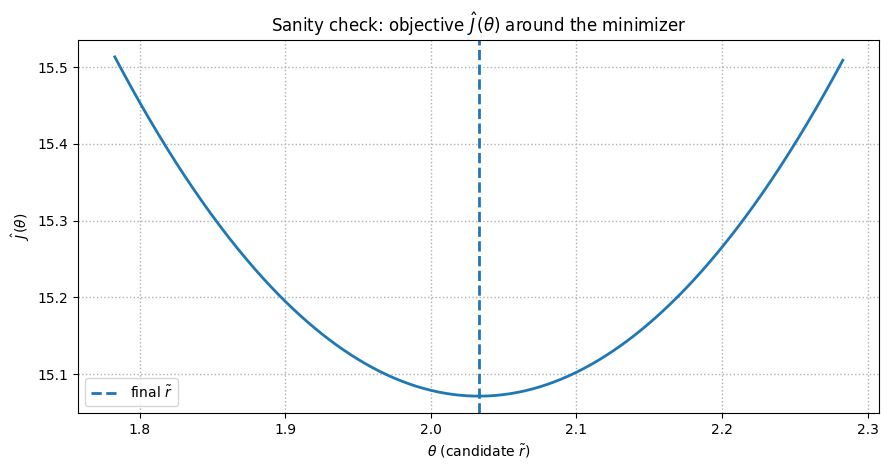

In [10]:
# Sanity check plot: J(theta) around the final minimizer 

X = adaptive_result["last_X"]
payoffs = adaptive_result["last_payoffs"]
f_r_vals = adaptive_result["last_f_r_vals"]
f_rt_vals_current = adaptive_result["last_f_rt_vals"]

if X is None:
    print("\nNo sample stored for J(theta) sanity plot (algorithm may have stopped before sampling).")
else:
    r_tilde_final = adaptive_result["r_tilde_final"]
    r_min = adaptive_result["r_min"]
    r_max = adaptive_result["r_max"]
    hw = adaptive_result["refine_half_width"]
    n_refine = adaptive_result["n_refine"]
    var_X = adaptive_result["var_X"]
    eps_denom = adaptive_result["eps_denom"]

    lo = max(r_min, r_tilde_final - hw)
    hi = min(r_max, r_tilde_final + hw)
    r_grid_plot = np.linspace(lo, hi, n_refine)

    f_r_sq = f_r_vals ** 2
    J_plot = np.empty_like(r_grid_plot, dtype=float)

    for j, r_candidate in enumerate(r_grid_plot):
        mu_cand, _ = log_price_params(r_candidate, sigma, T)
        f_cand = normal_pdf(X, mu_cand, var_X)
        denom = (f_cand * f_rt_vals_current) + eps_denom
        J_plot[j] = np.mean((payoffs ** 2) * f_r_sq / denom)

    plt.figure(figsize=(9, 4.8))
    plt.plot(r_grid_plot, J_plot, linewidth=2)
    plt.axvline(r_tilde_final, linestyle='--', linewidth=2, label=r"final $\tilde r$")
    plt.xlabel(r"$\theta$ (candidate $\tilde r$)")
    plt.ylabel(r"$\hat J(\theta)$")
    plt.title(r"Sanity check: objective $\hat J(\theta)$ around the minimizer")
    plt.grid(True, which='both', linestyle=':', linewidth=1)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Quantification of Variance Reduction - Crude Monte Carlo vs Adaptive Importance Sampling

In [11]:

print("Absolute errors from Black-Scholes price:")
print("\t For N =  " + str(adaptive_result['N_final']) + ": " + str(abs(adaptive_result['Z_hat'] - bs_price)))

print("\nVariance Reduction (CMC vs Adaptive IS):")
print("N final for adaptive IS: " + str(adaptive_result['N_final']))
print("Final standard deviation of weighted payoff: " + str(adaptive_result['sigma_hat']))
print("Variance Reduction: " + str((std_payoff_arr[-1] ** 2) / (adaptive_result['sigma_hat'] ** 2)))

Absolute errors from Black-Scholes price:
	 For N =  8000: 0.031016388148905172

Variance Reduction (CMC vs Adaptive IS):
N final for adaptive IS: 8000
Final standard deviation of weighted payoff: 2.2176522615636065
Variance Reduction: 17.88764756666301


## Comments on adaptive importance sampling
Performance for tolerance (tol) = 1e-3:
- Execution time: 6m1.0s
- Iterations    : 18
- r_tilde_final : 2.03
- N_final       : 32768000
- Z_hat         : 3.2182141337687673
- sigma_hat     : 2.2164958762434037
- Var reduction : 17.585903014316713

Performance for tolerance (tol) = 5e-2:
- Execution time: 0.1s
- Iterations    : 6
- r_tilde_final : 2.033
- N_final       : 8000
- Z_hat         : 3.1866129699491994
- sigma_hat     : 2.2176522615636065
- Var reduction : 17.56756760767114

## 2.1.4 PDE-based optimal control
We:
1. Build spatial and temporal grids.
2. Assemble the tridiagonal matrix for the implicit time-stepping scheme.
3. Solve backward in time for $v(t, s)$.
4. Compute $\zeta^*(t, s) = \sigma s \partial_s log\; v(t, s)$ by finite differences.
5. Use $\zeta^*$ in an importance sampling scheme for the SDE using EM and Girsanov weights.

In [12]:
def solve_optimal_control_pde(S0, K, T, r, sigma, M, P):
    """
    Solves the Kolmogorov Backward Equation and computes the optimal control zeta*.
    
    Returns:
    s: Asset price grid
    t_values: Time grid
    zeta_star: 2D array of optimal control values
    """
    
    S_min = S0 * np.exp((r - 0.5 * sigma**2) * T - 6 * sigma * np.sqrt(T))
    S_max = S0 * np.exp((r - 0.5 * sigma**2) * T + 6 * sigma * np.sqrt(T))
    
    s = np.linspace(S_min, S_max, P + 1)
    t_values = np.linspace(0, T, M + 1)
    ds = (S_max - S_min) / P
    dt = T / M

    v_history = np.zeros((M + 1, P + 1))
    v_history[M, :] = np.maximum(s - K, 0) * np.exp(-r*T) # Terminal condition v(T,s) = psi(s) 
    

    # Matrix assembly for implicit euler
    si = s[1:-1]
    L = (dt * r * si / (2 * ds)) - (dt * sigma**2 * si**2 / (2 * ds**2))
    D = 1 + (dt * sigma**2 * si**2 / ds**2)
    U = (-dt * r * si / (2 * ds)) - (dt * sigma**2 * si**2 / (2 * ds**2))
    A = diags([L[1:], D, U[:-1]], [-1, 0, 1], shape=(P-1, P-1), format='csc')

    for m in range(M - 1, -1, -1):
        t_m = m * dt
        rhs = v_history[m + 1, 1:-1].copy()
        
        # BCs
        v_min = 0
        v_max = S_max - K * np.exp(-r * (T - t_m))
        rhs[0] -= L[0] * v_min
        rhs[-1] -= U[-1] * v_max
        
        v_history[m, 1:-1] = spsolve(A, rhs)
        v_history[m, 0], v_history[m, -1] = v_min, v_max

    # Compute optimal control zeta*
    zeta_star = np.zeros_like(v_history)

    for m in range(M + 1):
        curr_dv_ds = np.zeros(P + 1)

        curr_dv_ds[1:-1] = (v_history[m, 2:] - v_history[m, :-2]) / (2 * ds)

        curr_dv_ds[0] = (v_history[m, 1] - v_history[m, 0]) / ds
        curr_dv_ds[-1] = (v_history[m, -1] - v_history[m, -2]) / ds
        
        safe_v = np.where(v_history[m, :] > 1e-14, v_history[m, :], 1e-14)
        zeta_star[m, :] = sigma * s * (1.0 / safe_v) * curr_dv_ds

    # Prolongate control from S_min + ds to avoid divergence at zero boundary
    zeta_star[:, 0] = zeta_star[:, 1]
    # Set control to zero at final time T
    zeta_star[M, :] = 0

    return s, t_values, zeta_star, v_history


def simulate_is_option_price(N, S0, K, T, r, sigma, M, control_func):
    """
    Vectorized Importance Sampling for European Call Option using Optimal Control.
    """
    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    S_curr = np.full(N, S0)
    log_L = np.zeros(N)
    
    for m in range(M):
        t_m = m * dt
        
        zeta_m = control_func(t_m, S_curr)
        dW = np.random.normal(0, sqrt_dt, size=N)
        log_L += -0.5 * (zeta_m**2) * dt - zeta_m * dW
        
        S_curr += (r * S_curr + sigma * S_curr * zeta_m) * dt + sigma * S_curr * dW
        
    payoffs = np.maximum(S_curr - K, 0) * np.exp(-r * T)
    weighted_payoffs = payoffs * np.exp(log_L)
    
    Z_is = np.mean(weighted_payoffs)
    Var_is = np.var(weighted_payoffs)
    error_is = 1.96 * np.sqrt(Var_is / N)
    
    return Z_is, Var_is, error_is


def monitor_is_convergence(n_range, S0, K, T, r, sigma, M, control_func, bs_price):
    """
    Simulates the evolution of the IS estimator and its error for different N.
    """
    estimates = []
    errors = []

    for N in tqdm(n_range, desc="Monitoring IS Convergence"):
        z_est, var_est, err_est = simulate_is_option_price(N, S0, K, T, r, sigma, M, control_func)
        
        estimates.append(z_est)
        errors.append(err_est)
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(n_range, estimates, yerr=errors, fmt='-o', color='b', 
                ecolor='lightblue', elinewidth=3, capsize=0, label='IS Estimator')
    plt.axhline(y=bs_price, color='r', linestyle='--', label='Black-Scholes Price')
    plt.xscale('log')
    plt.xlabel('Number of Simulations (N)')
    plt.ylabel('Estimated Option Price')
    plt.title('Evolution of IS Estimator and Confidence Interval')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()



### Computing the optimal control ζ\*(t, s)

We approximate:

$
 \partial_s \log v(t,s) \approx \frac{\log v(t, s_{j+1}) - \log v(t, s_{j-1})}{2 \Delta s},
$

and then set:

$
\zeta^*(t,s_j) = \sigma s_j \,\partial_s \log v(t,s_j).
$

At the left boundary $ s = S_{\min} $ we prolong the value from $ s = S_{\min} + \Delta s $
as suggested in the project. At final time T we set the control to zero.

In [13]:

def get_control_interpolator(t_grid, s_grid, zeta_star):
    """
    Creates a piecewise linear interpolator for the optimal control zeta*.
    
    Parameters:
    t_grid: 1D array of time points from 0 to T.
    s_grid: 1D array of asset price points from S_min to S_max.
    zeta_star: 2D array (matrix) of control values computed on the grid.
    """
    interp = RegularGridInterpolator((t_grid, s_grid), zeta_star, method='linear', bounds_error=False, fill_value=None)
    
    t_min, t_max = t_grid[0], t_grid[-1]
    s_min, s_max = s_grid[0], s_grid[-1]

    def evaluate_control(t, s_val):
        """
        Evaluates the control at (t, s_val) with constant extension outside the domain.
        """
        t_clipped = np.clip(t, t_min, t_max)
        s_clipped = np.clip(s_val, s_min, s_max)
        
        return interp((t_clipped, s_clipped))

    return evaluate_control


def plot_optimal_control(t_grid, s_grid, zeta_star, t_max=0.18, s_range=None):
    """
    Plots the optimal control zeta* using Plotly.
    
    Parameters:
    t_grid: 1D array of time points from 0 to T.
    s_grid: 1D array of asset price points from S_min to S_max.
    zeta_star: 2D array of control values (M+1, P+1).
    t_max: Upper bound for time axis (default 0.18).
    s_range: Tuple (S1, S2) for price axis filtering.
    """

    t_indices = np.where(t_grid <= t_max)[0]
    
    if s_range is not None:
        s1, s2 = s_range
        s_indices = np.where((s_grid >= s1) & (s_grid <= s2))[0]
    else:
        s_indices = np.arange(len(s_grid))

    t_plot = t_grid[t_indices]
    s_plot = s_grid[s_indices]
    
    # Z_plot: Rows correspond to Asset Price (y), Columns to Time (x)
    z_plot = zeta_star[np.ix_(t_indices, s_indices)].T

    fig = go.Figure(data=[go.Surface(
        z=z_plot, 
        x=t_plot, 
        y=s_plot,
        colorscale='Viridis',
        colorbar_title='ζ*'
    )])

    fig.update_layout(
        title=f'Optimal Control ζ*(t, s) for t ∈ [0, {t_max}]',
        scene=dict(
            xaxis_title='Time (t)',
            yaxis_title='Asset Price (s)',
            zaxis_title='Control ζ*',
            aspectmode='manual',
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        width=900,
        height=700,
        margin=dict(l=65, r=50, b=65, t=90)
    )

    fig.show()


## Simulating controlled SDE paths and computing the optimal-control IS estimator (Girsanov weight)
We now simulate the controlled SDE as in eq. (12) of the project spec, using $\zeta^*(t,s)$ and EM:

$S_\zeta^{m+1} = S_\zeta^m + [r S_\zeta^m + \sigma S_\zeta^m \zeta(t_m, S_\zeta^m)]\Delta t + \sigma S_\zeta^m \Delta W_m$,

while the Girsanov weight (discrete-time approximation of the exponential martingale in eq(5)) is:

$w(\{ \Delta W_m\}) = \exp\bigg( -\frac{1}{2}\sum_{m=0}^{M-1}\Delta t \zeta^2 (t_m, S_\zeta^m) - \sum_{m=0}^{M-1}\zeta(t_m, S_\zeta^m) \Delta W_m \bigg)$.

In [14]:
M = 30
P = 50
N_sim = 1_000_000
n_range = np.logspace(1, 6, num=30, dtype=int)

S1 = S0 * np.exp((r - 0.5 * sigma**2) * T - 3 * sigma * np.sqrt(T))
S2 = S0 * np.exp((r - 0.5 * sigma**2) * T + 3 * sigma * np.sqrt(T))

s_grid, t_grid, zeta_star, v_computed = solve_optimal_control_pde(S0, K, T, r, sigma, M, P)
plot_optimal_control(t_grid, s_grid, zeta_star, t_max=0.18, s_range=(S1, S2))

control_func = get_control_interpolator(t_grid, s_grid, zeta_star)
Z_is, Var_is, error_is = simulate_is_option_price(N_sim, S0, K, T, r, sigma, M, control_func)

# monitor_is_convergence(n_range, S0, K, T, r, sigma, M, control_func, bs_price)

print("-" * 30)
print(f"Numerical Setup: M={M}, P={P}, N={N_sim}")
print(f"S1: {S1:.2f}, S2: {S2:.2f}")
print("-" * 30)
print(f"Closed-form BS Price:  {bs_price:.6f}")
print(f"IS Estimate (Z_dt):    {Z_is:.6f}")
print(f"Statistical Error:     {error_is:.6f}")
print(f"IS Variance:           {Var_is:.4e}")
print(f"Relative Bias (%):     {abs(Z_is - bs_price)/bs_price * 100:.4f}%")
print(f"Absolute Bias (%):     {abs(Z_is - bs_price) * 100:.4f}%")
print("-" * 30)

------------------------------
Numerical Setup: M=30, P=50, N=1000000
S1: 49.65, S2: 195.08
------------------------------
Closed-form BS Price:  3.217629
IS Estimate (Z_dt):    3.201249
Statistical Error:     0.002134
IS Variance:           1.1850e+00
Relative Bias (%):     0.5091%
Absolute Bias (%):     1.6380%
------------------------------


In [15]:
def calculate_vrf(N, S0, K, T, r, sigma, M_pde, P_pde, M_sim, var_crude_ref):
    """
    Calculates the Variance Reduction Factor (VRF) of the IS estimator compared to the crude MC estimator.
    """
    s_grid, t_grid, zeta_star, _ = solve_optimal_control_pde(S0, K, T, r, sigma, M_pde, P_pde)
    control_func = get_control_interpolator(t_grid, s_grid, zeta_star)
    
    _, var_is, _ = simulate_is_option_price(N, S0, K, T, r, sigma, M_sim, control_func)
    print(f"Variance of IS estimator with N={N}: {var_is}")
    
    return var_crude_ref / var_is


Computation of the variance reduction factor for different discretization couples

In [16]:
N_test = 100_000
P_list = [20, 60, 100, 300, 500]
M_pde_list = [10, 50, 100, 500, 2000, 5000, 10000]

full_results = {}
vrf_results = {}

print(f"Variance of crude MC estimator with N={N_test}: {var_crude_ref}")


for m_val in M_pde_list:
    for p_val in P_list:
        start_time = time.time()
        s_grid, t_grid, zeta_star, _ = solve_optimal_control_pde(S0, K, T, r, sigma, m_val, p_val)
        ctrl_func = get_control_interpolator(t_grid, s_grid, zeta_star)
        z_is, var_is, err_is = simulate_is_option_price(N_test, S0, K, T, r, sigma, m_val, ctrl_func)
        
        end_time = time.time()
        elapsed = end_time - start_time
        
        full_results[(p_val, m_val)] = {
            'price': z_is,
            'variance': var_is,
            'error': err_is,
            'vrf': var_crude_ref / var_is,
            'time': elapsed
        }
        vrf_results[(p_val, m_val)] = var_crude_ref / var_is
        
        print(f"(P={p_val}, M={m_val}) | Price: {z_is:.8f} | VAR: {var_is:.8f} | VRF: {vrf_results[(p_val, m_val)]:.2f} | Time: {elapsed:.2f}s")



Variance of crude MC estimator with N=100000: 87.97112076331672
(P=20, M=10) | Price: 3.17412071 | VAR: 4.76933788 | VRF: 18.45 | Time: 0.15s
(P=60, M=10) | Price: 3.16421797 | VAR: 2.00111481 | VRF: 43.96 | Time: 0.09s
(P=100, M=10) | Price: 3.16904706 | VAR: 2.03557656 | VRF: 43.22 | Time: 0.09s
(P=300, M=10) | Price: 3.16718293 | VAR: 2.04574279 | VRF: 43.00 | Time: 0.11s
(P=500, M=10) | Price: 3.15691816 | VAR: 2.05547539 | VRF: 42.80 | Time: 0.13s
(P=20, M=50) | Price: 3.13790099 | VAR: 72.11914151 | VRF: 1.22 | Time: 0.38s
(P=60, M=50) | Price: 3.21116078 | VAR: 0.61692565 | VRF: 142.60 | Time: 0.43s
(P=100, M=50) | Price: 3.20817018 | VAR: 0.62895358 | VRF: 139.87 | Time: 0.45s
(P=300, M=50) | Price: 3.20759211 | VAR: 0.62209228 | VRF: 141.41 | Time: 0.50s
(P=500, M=50) | Price: 3.20188329 | VAR: 0.62301232 | VRF: 141.20 | Time: 0.51s
(P=20, M=100) | Price: 3.06032342 | VAR: 85.01341752 | VRF: 1.03 | Time: 0.80s
(P=60, M=100) | Price: 3.21331208 | VAR: 0.36397776 | VRF: 241.69 |

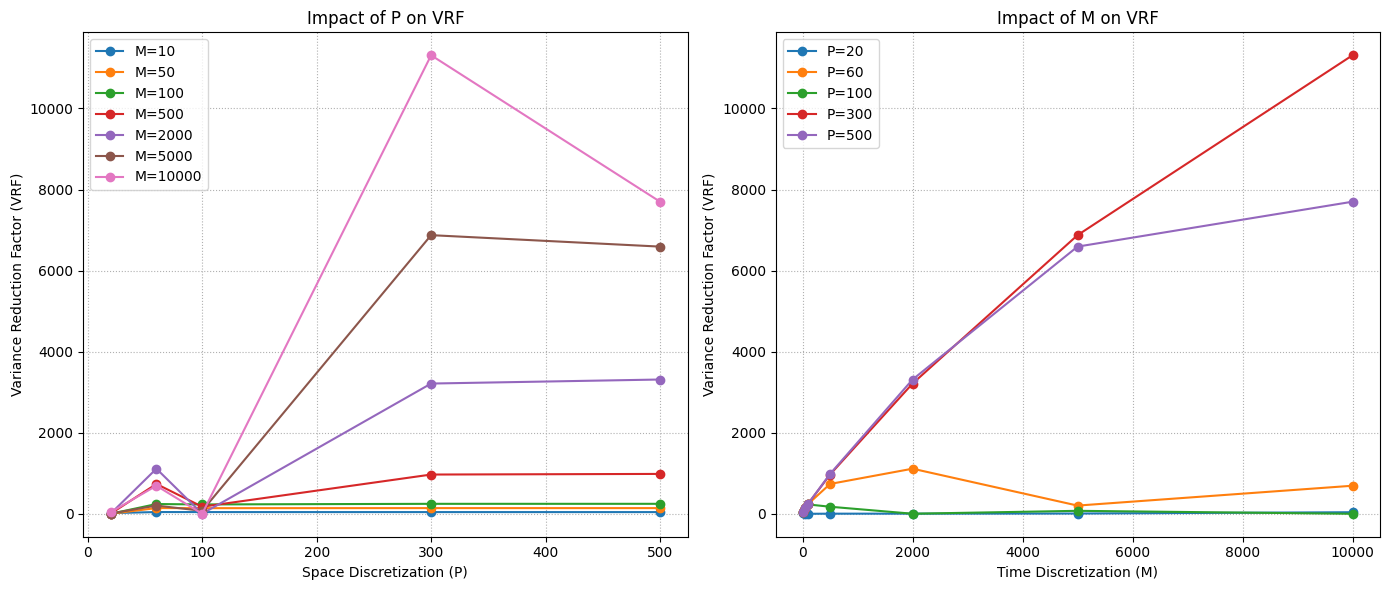

In [24]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for m_val in M_pde_list:
    y_values = [full_results[(p_val, m_val)]['vrf'] for p_val in P_list]
    plt.plot(P_list, y_values, '-o', label=f'M={m_val}')
plt.xlabel('Space Discretization (P)')
plt.ylabel('Variance Reduction Factor (VRF)')
plt.title('Impact of P on VRF')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.8)


plt.subplot(1, 2, 2)
for p_val in P_list:
    y_values = [full_results[(p_val, m_val)]['vrf'] for m_val in M_pde_list]
    plt.plot(M_pde_list, y_values, '-o', label=f'P={p_val}')
plt.xlabel('Time Discretization (M)')
plt.ylabel('Variance Reduction Factor (VRF)')
plt.title('Impact of M on VRF')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.show()

Comparison of different (time, space) couple refinements

In [22]:
def compare_couples_convergence(couples, n_range, S0, K, T, r, sigma, bs_price):
    """
    Compares the IS convergence for different (M,P) couples.
    """
    plt.figure(figsize=(10, 6))
    
    for (m_pde, p_pde) in couples:
        s_grid, t_grid, zeta_star, _ = solve_optimal_control_pde(S0, K, T, r, sigma, m_pde, p_pde)
        control_func = get_control_interpolator(t_grid, s_grid, zeta_star)
        
        estimates = []
        for N in n_range:
            z_est, _, _ = simulate_is_option_price(N, S0, K, T, r, sigma, m_pde, control_func)
            estimates.append(z_est)
            
        plt.plot(n_range, estimates, '-o', label=f'PDE Grid: M={m_pde}, P={p_pde}')
    
    plt.axhline(y=bs_price, color='r', linestyle='--', label='Black-Scholes Price')
    plt.xscale('log')
    plt.xlabel('Number of Simulations (N)')
    plt.ylabel('Estimated Option Price')
    plt.title('IS Convergence for Different PDE Discretizations')
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.8)
    plt.show()

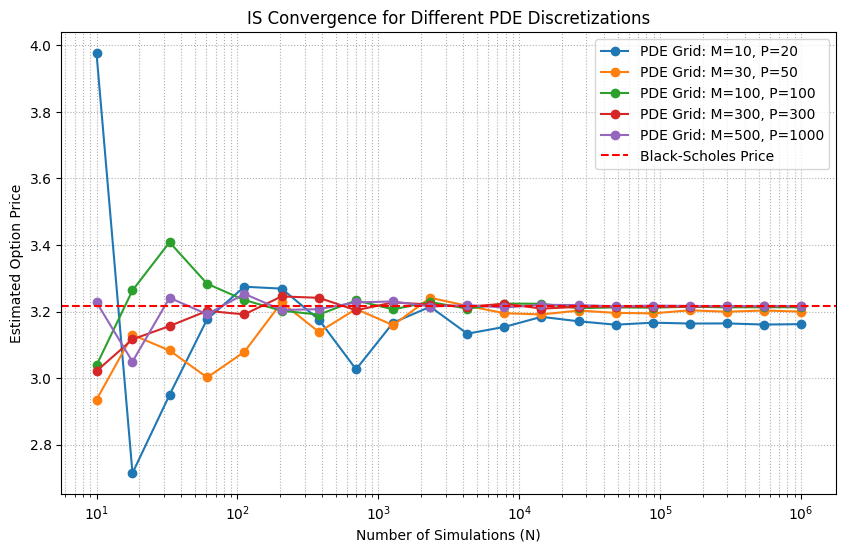

In [23]:
MP_couples = [(10, 20), (30, 50), (100, 100), (300, 300), (500, 1000)]
n_range = np.logspace(1, 6, num=20, dtype=int)
compare_couples_convergence(MP_couples, n_range, S0, K, T, r, sigma, bs_price)